# Packages Overview

## spekpy
[Overview](https://bitbucket.org/spekpy/spekpy_release/wiki/Home)

[Glossary](https://bitbucket.org/spekpy/spekpy_release/wiki/Function%20glossary)

## xraydb
[Overview](https://xraypy.github.io/XrayDB/)


In [1]:
from spectrumEstimations import SpekEstimations

import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp
import xraydb
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from roentgen.absorption import MassAttenuationCoefficient

In [2]:
## Parameters
kvp = 100. # Tube potential [kV] 
theta = 10.5 # Anode angle [deg.]
dx = 2. # Increment in lateral direction (= 0.5 in book figures) [cm]
z = 62.56 # Source-to-dector distance [cm]
dk = 0.5  # Width of energy bin [keV] 

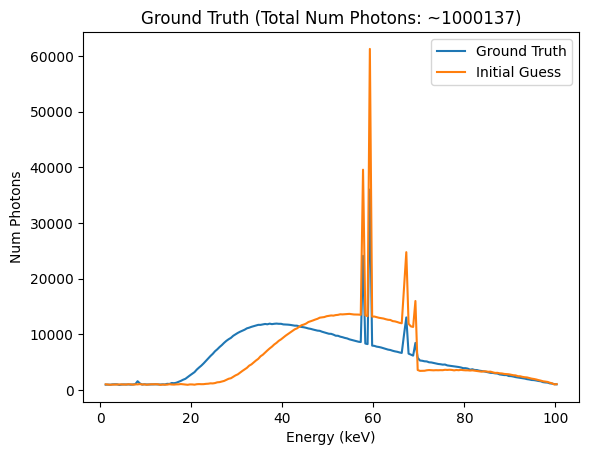

In [3]:
## Load Spectrum
spectrum = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=True,obli=False)
#spectrum.filter('Al',3.9)
spectrum.multi_filter([('C',1.94), ('Al',0.19), ('Cu',0.07)])
Es,spectra = spectrum.get_spectrum(addend=True)

numPhotons = np.random.poisson(10**6)
groundTruth = spectra/np.sum(spectra)*numPhotons + np.random.poisson(1000,len(Es)).astype(int)
groundTruth[groundTruth==0] = 1


## Get initial W guess
initialGuessObject = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=True,obli=False)
initialGuessObject.multi_filter([('W',0.08)])
_, initialGuess = initialGuessObject.get_spectrum(addend=True)
initialGuess = initialGuess/np.sum(initialGuess)*numPhotons + np.random.poisson(1000,len(Es)).astype(int)
initialGuess[initialGuess==0] = 1


plt.figure()
plt.plot(Es, groundTruth, label="Ground Truth")
plt.plot(Es,initialGuess,label="Initial Guess",linestyle="-")
plt.title("Ground Truth (Total Num Photons: ~{})".format(numPhotons))
plt.ylabel("Num Photons")
plt.xlabel("Energy (keV)")
plt.legend()

[[2.15577593e-077 0.00000000e+000 4.80571875e-196 ... 9.54782924e-001
  9.54950884e-001 9.55091743e-001]
 [7.74874289e-098 0.00000000e+000 3.95270052e-248 ... 9.43074238e-001
  9.43284384e-001 9.43460628e-001]
 [2.78521601e-118 0.00000000e+000 3.25109358e-300 ... 9.31509137e-001
  9.31760411e-001 9.31971157e-001]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 8.13281211e-001
  8.13920445e-001 8.14456831e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 8.03307787e-001
  8.03976893e-001 8.04538369e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 7.93456670e-001
  7.94154820e-001 7.94740694e-001]]


/Users/ktmath/Desktop/Fall23/BENG280A/project1/code/BENG280ACode/spectrumEstimations.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  G_j = self.Ws[j]/np.sum(self.A[:,j])
/Users/ktmath/Desktop/Fall23/BENG280A/project1/code/BENG280ACode/spectrumEstimations.py:101: RuntimeWarning: invalid value encountered in scalar multiply
  self.Ws[j] = G_j*R_j[j]


[[2.15577593e-077 0.00000000e+000 4.80571875e-196 ... 9.54782924e-001
  9.54950884e-001 9.55091743e-001]
 [7.74874289e-098 0.00000000e+000 3.95270052e-248 ... 9.43074238e-001
  9.43284384e-001 9.43460628e-001]
 [2.78521601e-118 0.00000000e+000 3.25109358e-300 ... 9.31509137e-001
  9.31760411e-001 9.31971157e-001]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 8.13281211e-001
  8.13920445e-001 8.14456831e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 8.03307787e-001
  8.03976893e-001 8.04538369e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 7.93456670e-001
  7.94154820e-001 7.94740694e-001]]
[[2.15577593e-077 0.00000000e+000 4.80571875e-196 ... 9.54782924e-001
  9.54950884e-001 9.55091743e-001]
 [7.74874289e-098 0.00000000e+000 3.95270052e-248 ... 9.43074238e-001
  9.43284384e-001 9.43460628e-001]
 [2.78521601e-118 0.00000000e+000 3.25109358e-300 ... 9.31509137e-001
  9.31760411e-001 9.31971157e-001]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000

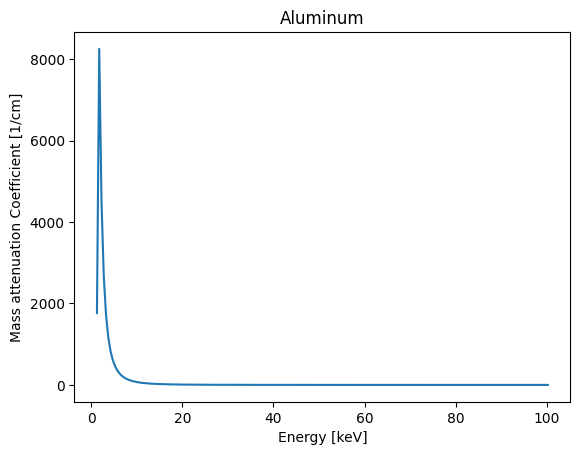

In [4]:
plot = True
## Prepare Simulation 
phantomLengths = np.linspace(0.1,0.5,16,endpoint=True)
spectrum = Es, groundTruth

## Preparing Mu values
materials  = [('Al',2.7)]
materialMus =np.zeros((len(materials), len(Es)))
for i in range(len(materials)):
    atten = MassAttenuationCoefficient(materials[i][0])
    energy = u.Quantity(Es, 'keV')
    materialMus[i] = atten.func(energy)*materials[i][1] 
    if plot:
        plt.figure()
        plt.plot(Es, materialMus[i])
        plt.xlabel('Energy [' + str(energy.unit) + ']')
        plt.ylabel('Mass attenuation Coefficient [1/cm]')
        plt.title(atten.name)
        



## Estimate Spectrum
estimationObj = SpekEstimations(materialMus,phantomLengths,initialGuess,spectrum)
estimateWs = estimationObj.getSpectrum()
#estimationObj.plotSpectrum()
